In [36]:
import pandas as pd
from pandas.plotting import andrews_curves, parallel_coordinates
import numpy as np
import math
from scipy import interpolate

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVR, NuSVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import KernelPCA, PCA
from joblib import dump, load

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib.collections import PolyCollection
plt.rcParams["lines.linewidth"] = 1.0
plt.rcParams["font.size"] = 6.0
plt.rcParams["axes.titlesize"] = 6.0

# Auxiliary Functions

In [2]:
def compute_uncertainty_matrix(X, frequencies, a=10, b=110, offset=61):
    """
    Function to compute matrix of uncertainties, i.e., for each experiment and
    real and imaginary parts (at each frequency).

    Input
    -----
    X: matrix with impedance measurements in Ohm of shape (n, p)
    f: vector of frequencies of shape (p / 2)
    a, b: two constants
    offset: offset for real and imaginary parts

    Output
    ------
    u_x: matrix with uncertaintie of shape (n, p)
    """
    n, p = X.shape  # get shape of data
    u_x = np.zeros((n, p))  # assign memory

    for i in range(n):  # loop over all experiments
        for k, f in enumerate(frequencies):  # loop over all frequencies
            f_kHz = f * 1e-3  # transform frequency to kHz
            c, d = 2.5 + 35 * f_kHz, 0.2 + 0.04 / f_kHz  # constants from documentation
            Re, Im = X[i, k], X[i, offset + k]  # get real and imaginary parts
            alpha = np.arctan(Im / Re)  # compute angle alpha
            Z_norm = np.sqrt(Re ** 2 + Im ** 2)  # compute |Z|

            # Compute uncertainties.
            u_z = np.sqrt(a ** 2 + b ** 2 * Z_norm ** 2)  # uncertainty of |Z| in uOhm
            u_alpha = np.sqrt(c + d ** 2 / Z_norm ** 2)  # uncertainty of angle in mdeg
            
            # Compute uncertainties.
            u_Re = np.sqrt((Z_norm * np.sin(alpha) * u_alpha) ** 2 + (np.cos(alpha) * u_z) ** 2) * 1e-6  # in Ohm
            u_Im = np.sqrt((Z_norm ** 2 * np.cos(alpha) * u_alpha) ** 2 + (np.sin(alpha) * u_z) ** 2) * 1e-6 # in Ohm

            # Story uncertainties.
            u_x[i, k], u_x[i, offset + k] = u_Re, u_Im

    return u_x

# Preprocessing

This does not need to be executed unless one wants to redo preprocessing of original data.

In [3]:
# Load data.
EIS = pd.read_csv("./datasets/data_EIS.csv")

# Remove bad data.
EIS = EIS.loc[np.asarray(["Inst5" not in id for id in EIS["Cell_ID"]])] # institution 5
EIS = EIS.loc[np.asarray(["Inst6" not in id for id in EIS["Cell_ID"]])] # institution 6
lct_id = "1_02"
cell_id = "Inst1-04"
frequencies = np.unique(EIS[((EIS["LCT_ID"] == lct_id) & (EIS["Cell_ID"] == cell_id))]["freq_Hz"].values)

In [14]:
# Load metadata.
metadata = pd.read_csv("./datasets/metadata.csv", index_col=0)
metadata.head(n=17)

,Institution,T_cycle_degC,T_EIS_degC,SOC_cycle_high,DOD_cycle,I_cycle_A
LCT_ID,,,,,,
1_01,Institution 5,45,23,100,100,4
1_02,Institution 1,45,23,100,100,4
1_03,Institution 6,45,23,100,100,4
1_04,Institution 2,45,23,100,100,4
1_05,Institution 3,45,23,100,100,4
1_06,Institution 4,45,23,100,100,4
1_10,Institution 1,35,23,100,100,4
1_11,Institution 1,45,23,75,50,4
1_13,Institution 3,23,23,100,100,4


In [15]:
# Transform data.
n = 2 * frequencies.shape[0]
lct_ids = np.unique(EIS.LCT_ID)
cell_ids = np.unique(EIS.Cell_ID)
sohs = np.unique(EIS.SOH[EIS.SOH >= 0.5])
socs = np.unique(EIS.SOC)
input = np.array([])
output = np.array([])
output2 = np.array([])
temperature = np.array([])

for lct_id in lct_ids:
    T_exp = metadata.loc[str(lct_id)]["T_cycle_degC"]
    for cell_id in cell_ids:
        for soc in socs:
            for soh in sohs:
                point = EIS[((EIS["LCT_ID"] == lct_id) & (EIS["Cell_ID"] == cell_id) & (EIS["SOC"] == soc) & (EIS["SOH"] == soh))]
                frequency = point[["freq_Hz"]].values
                if len(frequency > 0):
                    Z_real, Z_imag = point[["Zreal_ohm"]].values, point[["Zimag_ohm"]].values
                    f_real, f_imag = interpolate.interp1d(frequency.ravel(), Z_real.ravel(), bounds_error=False), interpolate.interp1d(frequency.ravel(), Z_imag.ravel(), bounds_error=False)
                    if len(input) == 0:
                        input = np.concatenate((f_real(frequencies), f_imag(frequencies)), axis=0)
                        output = soh
                        output2 = soc
                        input, output, output2 = np.expand_dims(input, axis=0), np.expand_dims(output, axis=0), np.expand_dims(output2, axis=0)
                        temperature = np.expand_dims(T_exp, axis=0)
                    else:
                        input = np.concatenate((input, 
                                                np.expand_dims(np.concatenate((f_real(frequencies), 
                                                                               f_imag(frequencies)), axis=0), axis=0)), 
                                                                               axis=0)
                        output = np.concatenate((output, np.asarray([soh])))
                        output2 = np.concatenate((output2, np.asarray([soc])))
                        temperature = np.concatenate((temperature, np.asarray([T_exp])))

In [16]:
# Store data.
arrays = [["Z_real"] * 61 + ["Z_imag"] * 61, 2 * list(frequencies)]
tuples = list(zip(*arrays))
pd.DataFrame(input, columns=tuples).to_csv("input.csv")
pd.DataFrame(output, columns=["SOH"]).to_csv("output.csv")
pd.DataFrame(output2, columns=["SOC"]).to_csv("output2.csv")
pd.DataFrame(temperature, columns=["T_cycle"]).to_csv("temperature.csv")

# Modeling

In [37]:
# Load data.
input = pd.read_csv("input.csv", index_col=0)
output = pd.read_csv("output.csv", index_col=0) # state of health (SOH)
output2 = pd.read_csv("output2.csv", index_col=0) # state of charge (SOC)

In [175]:
# Show input data.
input.describe()

# Comment: First variable has quite a few missing values.

,"('Z_real', 0.01)","('Z_real', 0.01259)","('Z_real', 0.01585)","('Z_real', 0.01995)","('Z_real', 0.02512)","('Z_real', 0.03162)","('Z_real', 0.03981)","('Z_real', 0.05012)","('Z_real', 0.0631)","('Z_real', 0.07943)",...,"('Z_imag', 1258.92517)","('Z_imag', 1584.89294)","('Z_imag', 1995.26208)","('Z_imag', 2511.88623)","('Z_imag', 3162.27734)","('Z_imag', 3981.07129)","('Z_imag', 5011.87207)","('Z_imag', 6309.57324)","('Z_imag', 7943.28223)","('Z_imag', 10000.0)"
count,3208.000000,3805.000000,3830.000000,3830.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,...,3833.000000,3833.000000,3833.000000,3833.000000,3833.000000,3833.000000,3833.000000,3833.000000,3833.000000,3815.000000
mean,0.040576,0.038274,0.037275,0.036430,0.035621,0.034949,0.034269,0.033663,0.033038,0.032442,...,0.000576,0.001089,0.001719,0.002500,0.003454,0.004619,0.006040,0.007776,0.009902,0.012499
std,0.026239,0.024431,0.024264,0.023912,0.023470,0.022918,0.022227,0.021384,0.020381,0.019232,...,0.000366,0.000447,0.000555,0.000681,0.000837,0.001030,0.001273,0.001578,0.001958,0.002430
min,0.023730,0.022709,0.022000,0.021392,0.020880,0.020469,0.020134,0.019839,0.019568,0.019333,...,-0.001396,-0.001185,-0.000912,-0.000518,-0.000035,0.000572,0.001220,0.001794,0.002487,0.003342
25%,0.028340,0.027121,0.026160,0.025434,0.024738,0.024245,0.023755,0.023386,0.023024,0.022708,...,0.000360,0.000857,0.001458,0.002189,0.003076,0.004149,0.005462,0.007048,0.009002,0.011373
50%,0.031605,0.030216,0.029237,0.028502,0.027746,0.027201,0.026634,0.026210,0.025761,0.025428,...,0.000577,0.001080,0.001724,0.002499,0.003458,0.004626,0.006048,0.007773,0.009867,0.012415
75%,0.040529,0.038057,0.036994,0.036132,0.035299,0.034636,0.034006,0.033514,0.033039,0.032625,...,0.000896,0.001477,0.002205,0.003103,0.004181,0.005494,0.007109,0.009091,0.011523,0.014511
max,0.394220,0.386223,0.376157,0.362494,0.345258,0.322698,0.294470,0.263890,0.226978,0.195631,...,0.001247,0.001904,0.002713,0.003714,0.004946,0.006456,0.008309,0.010586,0.013386,0.016815


In [38]:
# Preprocess data.

# Impute missing values.
imputer = SimpleImputer()
imp_input = imputer.fit_transform(input)

# Remove some anomalies.
detector = IsolationForest(n_estimators=500, contamination=0.05, random_state=0, n_jobs=-1)
regularities = np.array((detector.fit_predict(imp_input) + 1)/2, dtype=bool)
clean_input, clean_output, clean_output2 = imp_input[regularities, :], output[regularities], output2[regularities]

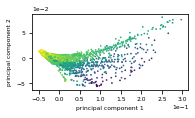

In [27]:
pca = PCA(n_components=2, random_state=0)
Y = pca.fit_transform(clean_input)
color = plt.cm.viridis((clean_output.values.T - np.min(clean_output.values.T))/(np.max(clean_output.values.T) - np.min(clean_output.values.T)))[0, :, :]

fig, axes = plt.subplots(1, 1, figsize=(2.8, 0.5*2.8), sharex=True, sharey=True, facecolor="white")
axes.scatter(Y[:, 0], Y[:, 1], s=2, c=color , marker=".",
            norm=True, alpha=1.0)
axes.set_xlabel(r"principal component 1")
axes.set_ylabel(r"principal component 2")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.savefig("./figures/soh/pca.png", dpi=1200, orientation='landscape', bbox_inches='tight')
plt.show()

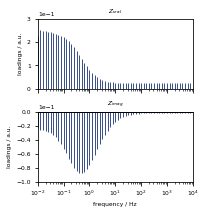

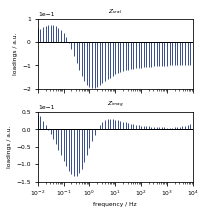

In [41]:
fig, axes = plt.subplots(2, 1, figsize=(2.95, 2.95),  sharex=True, sharey=False, facecolor="white")
fig.tight_layout(pad=3.0)
axes[0].set_title(r"$Z_{real}$")
axes[1].set_title(r"$Z_{imag}$")
markerline, stemlines, baseline = axes[0].stem(frequencies, pca.components_[0, :61], markerfmt="None")
stemlines.set_color(plt.cm.viridis(0.25))
baseline.set_color("k")
markerline, stemlines, baseline = axes[1].stem(frequencies, pca.components_[0, 61:], markerfmt="None")
stemlines.set_color(plt.cm.viridis(0.25))
baseline.set_color("k")
axes[1].set_xlabel("frequency / Hz")
axes[0].set_ylabel("loadings / a.u.")
axes[1].set_ylabel("loadings / a.u.")
axes[0].set_xscale("log")
axes[0].set_yscale("linear")
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
axes[0].set_ylim(0, 3e-1)
axes[1].set_ylim(-10e-2, 0)
axes[0].set_xlim(1e-2, 1e4)
plt.savefig("./figures/soh/loadings1.png", dpi=1200, orientation='landscape', bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(2.95, 2.95),  sharex=True, sharey=False, facecolor="white")
fig.tight_layout(pad=3.0)
axes[0].set_title(r"$Z_{real}$")
axes[1].set_title(r"$Z_{imag}$")
markerline, stemlines, baseline = axes[0].stem(frequencies, pca.components_[1, :61], markerfmt="None")
stemlines.set_color(plt.cm.viridis(0.25))
baseline.set_color("k")
markerline, stemlines, baseline = axes[1].stem(frequencies, pca.components_[1, 61:], markerfmt="None")
stemlines.set_color(plt.cm.viridis(0.25))
baseline.set_color("k")
axes[1].set_xlabel("frequency / Hz")
axes[0].set_ylabel("loadings / a.u.")
axes[1].set_ylabel("loadings / a.u.")
axes[0].set_xscale("log")
axes[0].set_yscale("linear")
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
axes[0].set_xlim(1e-2, 1e4)
axes[0].set_ylim(-2e-1, 1e-1)
axes[1].set_ylim(-1.5e-1, 0.5e-1)
plt.savefig("./figures/soh/loadings2.png", dpi=1200, orientation='landscape', bbox_inches='tight')
plt.show()

# State of Health

NuSVR is a robust method, but nu parameter (together with gamma and C) need to be estimated through CV.

In [191]:
# Retrain model.
model = NuSVR(kernel="rbf")
params = dict(C=np.logspace(-1, 2, 20), gamma=np.logspace(-1, 3, 20), nu=np.linspace(0.05, 0.5, 20))
clf = RandomizedSearchCV(model, params, cv=5, scoring="r2", n_iter=50, n_jobs=-1, random_state=0)
clf.fit(clean_input, clean_output)
dump(clf, "soh_model.joblib")

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


['model.joblib']

Instead of retraining model, load a saved version thereof.

In [80]:
# Load model.
clf = load("soh_model.joblib")

# Compute a few metrics.
y_pred = clf.predict(clean_input).ravel()
y_true = clean_output.values.ravel()
indeces = np.argsort((y_true - y_pred) ** 2) # remove one anomaly (weird sample)
r2 = r2_score(y_true[indeces[:-1]], y_pred[indeces[:-1]])
rmse = np.sqrt(mean_squared_error(y_true[indeces[:-1]], y_pred[indeces[:-1]]))

In [81]:
print("The best R2-score achieved is", np.round(r2, 2), ".")
print("The best RMSE achieved is", np.round(rmse, 4), ".")

The best R2-score achieved is 0.99 .
The best RMSE achieved is 0.0082 .


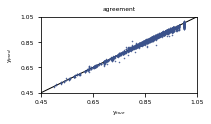

In [44]:
fig, axes = plt.subplots(1, 1, figsize=(2.8, 0.5*2.8), sharex=True, sharey=True, facecolor="white")
axes.set_title("agreement")
axes.plot([0.4, 1.1], [0.4, 1.1], "-k")
axes.plot(y_true[indeces[:-1]], y_pred[indeces[:-1]], ".", ms=1, color=plt.cm.viridis(0.25))
# axes.plot(y_true[indeces[-1]], y_pred[indeces[-1]], ".", ms=1, color=plt.cm.viridis(0.25))
axes.set_xlim(0.45, 1.05)
axes.set_xticks(ticks=np.linspace(0.45, 1.05, 4))
axes.set_yticks(ticks=np.linspace(0.45, 1.05, 4))
axes.set_ylim(0.45, 1.05)
axes.set_xlabel("y$_{true}$")
axes.set_ylabel("y$_{pred}$")
plt.savefig("./figures/soh/agreement.png", dpi=1200, orientation='landscape', bbox_inches='tight')
plt.show()

In [16]:
# Compute permutation importance.
fi = permutation_importance(clf, X=clean_input[indeces[:-1], :], y=clean_output.values[indeces[:-1], :], n_repeats=10, scoring="r2", n_jobs=-1, random_state=0)

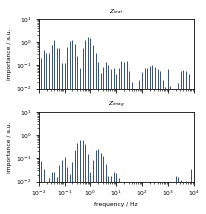

In [79]:
fig, axes = plt.subplots(2, 1, figsize=(2.95, 2.95),  sharex=True, sharey=True,facecolor="white")
fig.tight_layout(pad=3.0)
axes[0].set_title(r"$Z_{real}$")
axes[1].set_title(r"$Z_{imag}$")
markerline, stemlines, baseline = axes[0].stem(frequencies, fi["importances_mean"][:61], markerfmt="None")
stemlines.set_color(plt.cm.viridis(0.25))
markerline, stemlines, baseline = axes[1].stem(frequencies, fi["importances_mean"][61:], markerfmt="None")
stemlines.set_color(plt.cm.viridis(0.25))
axes[1].set_xlabel("frequency / Hz")
axes[0].set_ylabel("importance / a.u.")
axes[1].set_ylabel("importance / a.u.")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlim(1e-2, 1e4)
axes[0].set_ylim(1e-2, 1e1)
plt.savefig("./figures/soh/feature_importance.png", dpi=1200, orientation='landscape', bbox_inches='tight')
plt.show()

In [17]:
# Compute order of importance.
imp_Z_real = np.argsort(fi["importances_mean"][:61])[::-1]
imp_Z_imag = np.argsort(fi["importances_mean"][61:])[::-1]

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


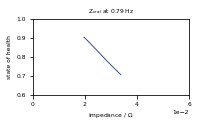

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


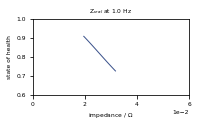

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


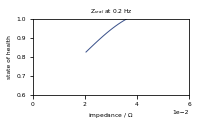

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


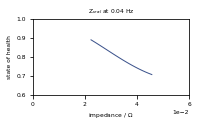

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


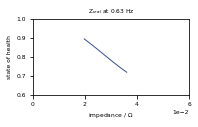

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


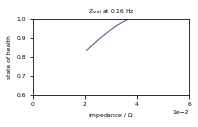

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


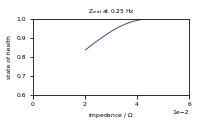

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


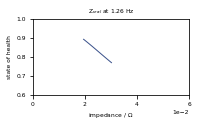

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


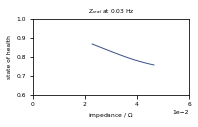

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


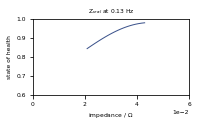

In [94]:
# Compute partial dependence.
n_features = 10
for i in range(n_features):
    pdp = partial_dependence(clf, features=[imp_Z_real[i]], X=clean_input[indeces[:-1], :], percentiles=(0.1, 0.9), grid_resolution=20) 
    average, values = pdp
    plt.figure(figsize=(2.8, 0.5*2.8), facecolor="white")
    plt.plot(values[0].flatten(), average.flatten(), color=plt.cm.viridis(0.25))
    plt.title("Z$_{real}$ at " + str(np.round(frequencies[imp_Z_real[i]], 2)) + " Hz")
    plt.xlabel("impedance / $\Omega$")
    plt.ylabel("state of health")
    plt.xlim(0.0, 0.06)
    plt.xticks(np.linspace(0.00, 0.06, 4))
    plt.ylim(0.6, 1.0)
    plt.yticks(np.linspace(0.6, 1.0, 5))
    plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
    plt.savefig("./figures/soh/pdps/pdp_Z_real_"+str(i)+".png", dpi=1200, orientation='landscape', bbox_inches='tight')
    plt.show()

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


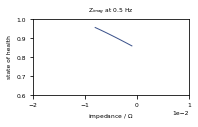

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


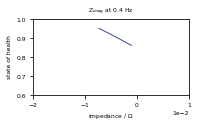

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


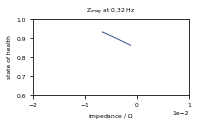

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


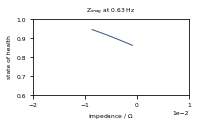

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


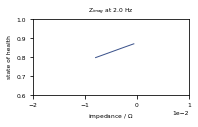

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


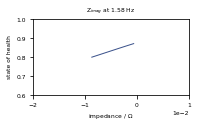

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


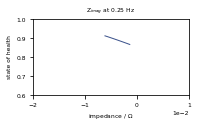

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


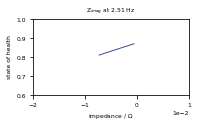

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


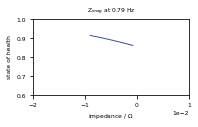

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


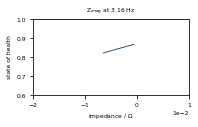

In [95]:
# Compute partial dependence.
n_features = 10
for i in range(n_features):
    pdp = partial_dependence(clf, features=[61+imp_Z_imag[i]], X=clean_input[indeces[:-1], :], percentiles=(0.1, 0.9), grid_resolution=20) 
    average, values = pdp
    plt.figure(figsize=(2.8, 0.5*2.8), facecolor="white")
    plt.plot(values[0].flatten(), average.flatten(), color=plt.cm.viridis(0.25))
    plt.title("Z$_{imag}$ at " + str(np.round(frequencies[imp_Z_imag[i]], 2)) + " Hz")
    plt.xlabel("impedance / $\Omega$")
    plt.ylabel("state of health")
    plt.xlim(-0.02, 0.01)
    plt.xticks(np.linspace(-0.02, 0.01, 4))
    plt.ylim(0.6, 1.0)
    plt.yticks(np.linspace(0.6, 1.0, 5))
    plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
    plt.savefig("./figures/soh/pdps/pdp_Z_imag_"+str(i)+".png", dpi=1200, orientation='landscape', bbox_inches='tight')
    plt.show()

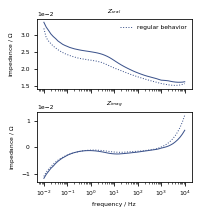

In [27]:
eps = 0.03
similar_health = ((output.values >= output.values[indeces[-1]] - eps) & (output.values <= output.values[indeces[-1]] + eps))[indeces[:-1], :].ravel()

fig, axes = plt.subplots(2, 1, figsize=(2.95, 2.95), sharex=True, facecolor="white")
fig.tight_layout(pad=3.0)
axes[0].set_title(r"$Z_{real}$")
axes[1].set_title(r"$Z_{imag}$")
axes[0].plot(frequencies, clean_input[indeces[-1], :61], "-", color=plt.cm.viridis(0.25))
axes[0].plot(frequencies, np.median(clean_input[indeces[:-1], :61][similar_health, :], axis=0), ":", color=plt.cm.viridis(0.25), label="regular behavior")
axes[1].plot(frequencies, clean_input[indeces[-1], 61:], "-", color=plt.cm.viridis(0.25))
axes[1].plot(frequencies, np.median(clean_input[indeces[:-1], 61:][similar_health, :], axis=0), ":", color=plt.cm.viridis(0.25), label="regular behavior")
axes[0].set_xscale("log")
axes[1].set_xlabel("frequency / Hz")
axes[0].set_ylabel("impedance / "+r"$\Omega$")
axes[1].set_ylabel("impedance / "+r"$\Omega$")
axes[0].legend(frameon=False)
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.savefig("./figures/soh/anomaly.png", dpi=1200, orientation='landscape',bbox_inches='tight')

In [7]:
# Save test data.
arrays = [["Z_real"] * 61 + ["Z_imag"] * 61, 2 * list(frequencies)]
tuples = list(zip(*arrays))
pd.DataFrame(data=clean_input, columns=np.array(tuples)).to_csv("X_test.csv")
pd.DataFrame(data=clean_output).to_csv("y_test.csv")

# Compute uncertainties.
u_x = compute_uncertainty_matrix(clean_input, frequencies)

# Save data.
pd.DataFrame(u_x, columns=np.array(tuples)).to_csv("u_x_test.csv")

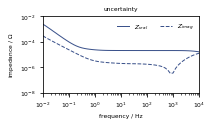

In [45]:
fig, axes = plt.subplots(1, 1, figsize=(2.8, 0.5*2.8), sharex=True, sharey=True, facecolor="white")
axes.set_title(r"uncertainty")
axes.plot(frequencies, 2 * np.mean(u_x[:, :61], axis=0), color=plt.cm.viridis(0.25), label=r"$Z_{real}$")
axes.plot(frequencies, 2 * np.mean(u_x[:, 61:], axis=0), "--", color=plt.cm.viridis(0.25), label=r"$Z_{imag}$")
axes.set_xscale("log")
axes.set_yscale("log")
# axes.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
axes.set_xlim(1e-2, 1e4)
axes.set_ylim(1e-8, 1e-2)
axes.set_xlabel("frequency / Hz")
axes.set_ylabel(r"impedance / $\Omega$")
plt.legend(frameon=False, ncol=2)
plt.savefig("./figures/uncertainty_impedance.png", dpi=1200, orientation='landscape',bbox_inches='tight')
plt.show()

# State of Charge

In [45]:
# Retrain model.
model = NuSVR(kernel="rbf")
params = dict(C=np.logspace(1, 4, 20), gamma=np.logspace(1, 4, 20), nu=np.linspace(0.05, 0.5, 20))
clf = RandomizedSearchCV(model, params, cv=5, scoring="r2", n_iter=50, n_jobs=-1, random_state=0)
clf.fit(clean_input, clean_output2)
dump(clf, "soc_model.joblib")

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


['soc_model.joblib']

In [22]:
# Load model.
clf = load("soc_model.joblib")

In [47]:
print("The best R2-score achieved is", np.round(clf.best_score_, 2), ".")

The best R2-score achieved is 0.77 .


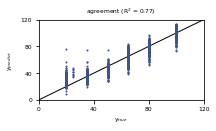

In [48]:
y_pred = clf.predict(clean_input)

plt.figure(figsize=(2.95, 0.5*2.95), facecolor="white")
plt.title("agreement (R$^2$ = "+str(np.round(clf.best_score_, 2))+")")
plt.plot([0, 120], [0, 120], "-k")
plt.plot(clean_output2, y_pred, ".", ms=2, color=plt.cm.viridis(0.25))
plt.xlim(0, 120)
plt.xticks(ticks=np.linspace(0, 120, 4))
plt.yticks(ticks=np.linspace(0, 120, 4))
plt.ylim(0, 120)
plt.xlabel("y$_{true}$")
plt.ylabel("y$_{predict}$")
plt.savefig("./figures/soc/agreement.png", dpi=1200, orientation='landscape', bbox_inches='tight')
plt.show()

In [49]:
# Compute permutation importance.
fi = permutation_importance(clf, X=clean_input, y=clean_output2, n_repeats=10, scoring="r2", n_jobs=-1, random_state=0)

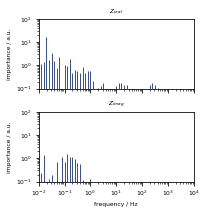

In [51]:
fig, axes = plt.subplots(2, 1, figsize=(2.95, 2.95), sharex=True, sharey=True, facecolor="white")
fig.tight_layout(pad=3.0)
axes[0].set_title(r"$Z_{real}$")
axes[1].set_title(r"$Z_{imag}$")
markerline, stemlines, baseline = axes[0].stem(frequencies, fi["importances_mean"][:61], markerfmt="None")
stemlines.set_color(plt.cm.viridis(0.25))
markerline, stemlines, baseline = axes[1].stem(frequencies, fi["importances_mean"][61:], markerfmt="None")
stemlines.set_color(plt.cm.viridis(0.25))
axes[1].set_xlabel("frequency / Hz")
axes[0].set_ylabel("importance / a.u.")
axes[1].set_ylabel("importance / a.u.")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_xlim(1e-2, 1e4)
axes[0].set_ylim(1e-1, 1e2)
plt.savefig("./figures/soc/feature_importance.png", dpi=1200, orientation='landscape', bbox_inches='tight')
plt.show()

In [36]:
# Compute order of importance.
imp_Z_real = np.argsort(fi["importances_mean"][:61])[::-1]
imp_Z_imag = np.argsort(fi["importances_mean"][61:])[::-1]

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


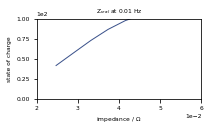

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


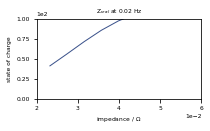

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


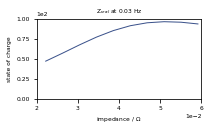

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


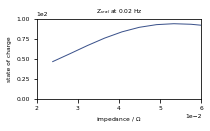

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


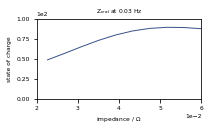

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


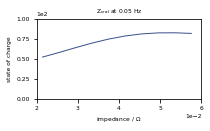

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


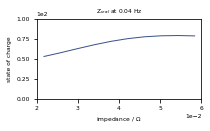

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


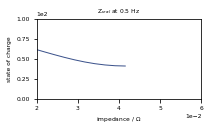

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


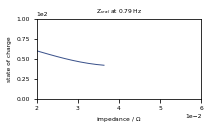

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


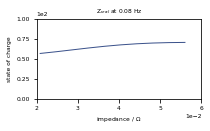

In [37]:
# Compute partial dependence.
n_features = 10
for i in range(n_features):
    pdp = partial_dependence(clf, features=[imp_Z_real[i]], X=clean_input, percentiles=(0.05, 0.95), grid_resolution=10, kind="individual") 
    average, values = pdp
    plt.figure(figsize=(2.95, 0.5*2.95), facecolor="white")
    plt.plot(values[0].flatten(), average.flatten(), color=plt.cm.viridis(0.25))
    plt.title("Z$_{real}$ at " + str(np.round(frequencies[imp_Z_real[i]], 2)) + " Hz")
    plt.xlabel("impedance / $\Omega$")
    plt.ylabel("state of charge")
    plt.xlim(0.02, 0.06)
    plt.xticks(np.linspace(0.02, 0.06, 5))
    plt.ylim(0, 100)
    plt.yticks(np.linspace(0, 100, 5))
    plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
    plt.savefig("./figures/soc/pdps/pdp_Z_real_"+str(i)+".png", dpi=1200, orientation='landscape', bbox_inches='tight')
    plt.show()

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


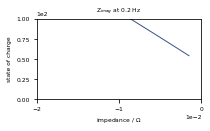

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


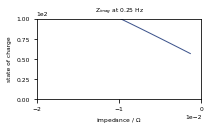

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


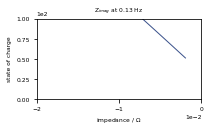

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


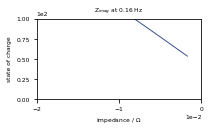

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


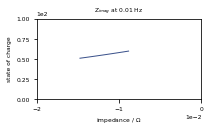

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


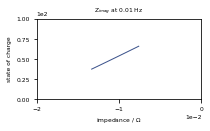

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


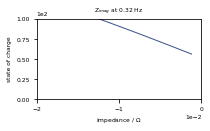

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


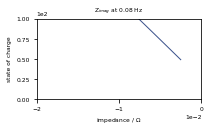

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


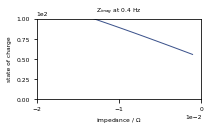

c:\Users\tage\Anaconda3\lib\site-packages\sklearn\inspection\_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


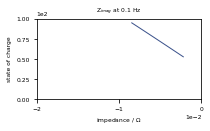

In [52]:
# Compute partial dependence.
n_features = 10
for i in range(n_features):
    pdp = partial_dependence(clf, features=[61+imp_Z_imag[i]], X=clean_input, percentiles=(0.05, 0.95), grid_resolution=10) 
    average, values = pdp
    plt.figure(figsize=(2.95, 0.5*2.95), facecolor="white")
    plt.plot(values[0].flatten(), average.flatten(), color=plt.cm.viridis(0.25))
    plt.title("Z$_{imag}$ at " + str(np.round(frequencies[imp_Z_imag[i]], 2)) + " Hz")
    plt.xlabel("impedance / $\Omega$")
    plt.ylabel("state of charge")
    plt.xlim(-0.02, 0.00)
    plt.xticks(np.linspace(-0.02, 0.00, 3))
    plt.ylim(0.8, 1.0)
    plt.yticks(np.linspace(0, 100, 5))
    plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
    plt.savefig("./figures/soc/pdps/pdp_Z_imag_"+str(i)+".png", dpi=1200, orientation='landscape', bbox_inches='tight')
    plt.show()